#### Import Packages

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Read Dataset

In [29]:
data = pd.read_csv('AirPassengers.csv')

#### Data Mining and Analysis

In [30]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [26]:
data['#Passengers'].describe()

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: #Passengers, dtype: float64

In [6]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [ ]:
## Right skewed plot: mean > median.
data['#Passengers'].hist(bins=50)

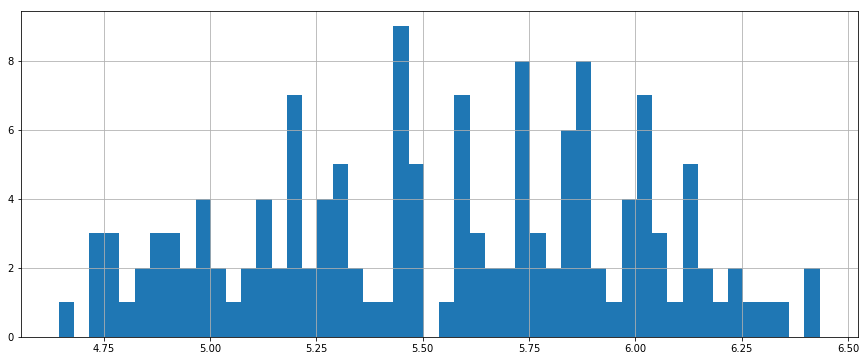

In [160]:
# Better representation as a Normal curve now.
np.log(data['#Passengers']).hist(bins=50)

#### The dataset is not read as a TS object as the data types are ‘object’ and ‘int’. Reading the data again as a time series.

In [31]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)

In [18]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [32]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [63]:
ts = data['#Passengers']

#### A simple trend plot to visualize the data
It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. 

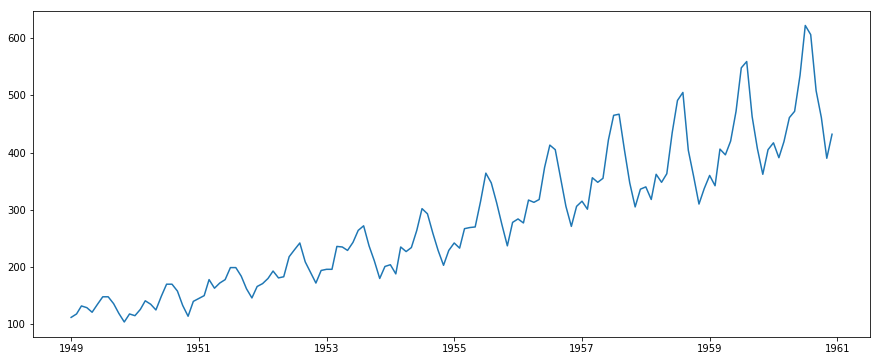

In [28]:
plt.plot(data)

We can check stationarity of a time-series using the following:
- Plotting Rolling Statistics: 
- Dickey-Fuller Test: 

In [36]:
from statsmodels.tsa.stattools import adfuller

In [46]:
def rolling_statistics(timeseries):
    
    # Determine Rolling statistics
    roll_mean = timeseries.rolling(window=12).mean()
    roll_std = timeseries.rolling(window=12).std()
    
    # PLotting Rolling statistics
    original_plot = plt.plot(timeseries, color='blue', label='Original')
    roll_mean_plot = plt.plot(roll_mean, color='red', label='Rolling Mean')
    roll_std_plot = plt.plot(roll_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

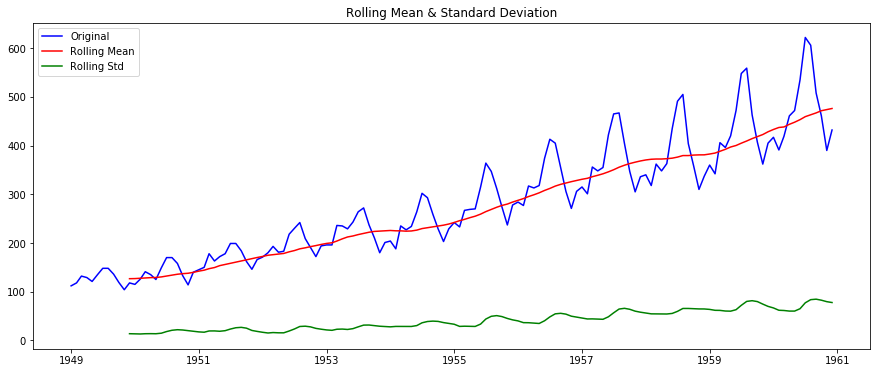

In [47]:
rolling_statistics(ts)

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. 

In [61]:
def adf_test(timeseries):
    # Perform Augmented Dickey-Fuller Test
    dfTest = adfuller(timeseries, autolag='AIC')
    
    # Formatting the output display
    dfoutput = pd.Series(dfTest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dfTest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [58]:
adf_test(ts)

ADF Test Statistic               0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


The test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.

#### Estimating & Eliminating Trend

*Transformation*: In this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc.

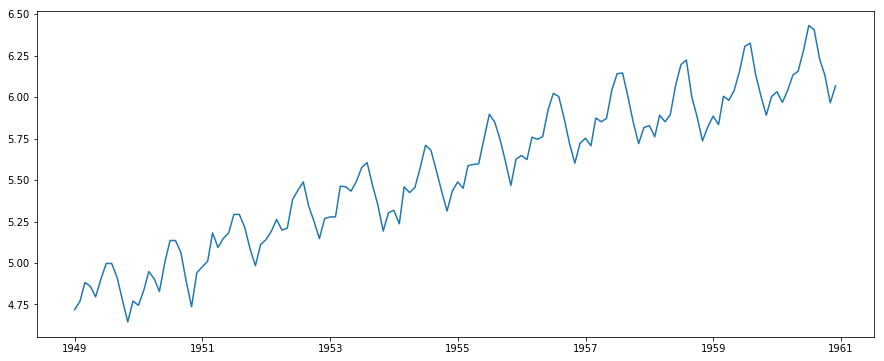

In [64]:
#  Taking a log transform here for simplicity:
ts_log = np.log(ts)
plt.plot(ts_log)

From the above plot, it can be seen the exponential growth seems diminished, but we still have a trend and seasonal elements.

In [78]:
# Calculate the mean and standard deviation of the values of the log transformed dataset.
split = int(len(ts_log)/2)
ts1_log, ts2_log = ts_log.values[:split], ts_log.values[split:]
mean_ts1_log, mean_ts2_log = ts1_log.mean(), ts2_log.mean()
std_ts1_log, std_ts2_log = ts1_log.std(), ts2_log.std()
print('Mean1 = %f , Mean2 = %f' % (mean_ts1_log, mean_ts2_log))
print('Std1 = %f, Std2 = %f' % (std_ts1_log, std_ts2_log))

Mean1 = 5.175146 , Mean2 = 5.909206
Std1 = 0.261486, Std2 = 0.221955


Mean and standard deviation values for each set are similar, but not identical.

#### Moving average
In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. 

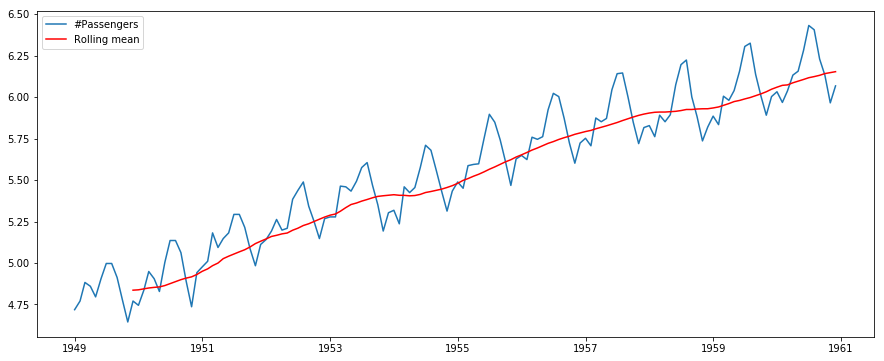

In [82]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red', label='Rolling mean')
plt.legend(loc='best')

Subtracting the log series from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values.

In [84]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

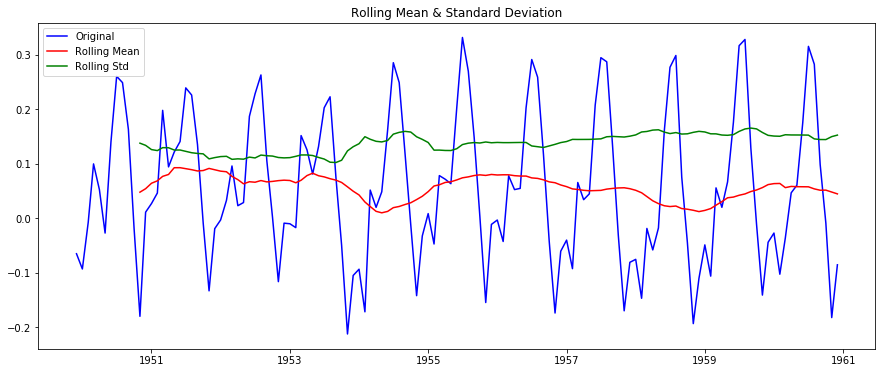

ADF Test Statistic              -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [85]:
# Dropping these NaN values and check the plots to test stationarity.
ts_log_moving_avg_diff.dropna(inplace=True)
rolling_statistics(ts_log_moving_avg_diff)
adf_test(ts_log_moving_avg_diff)

This looks like a better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

*Exponentially weighted moving average* where weights are assigned to all the previous values with a decay factor.

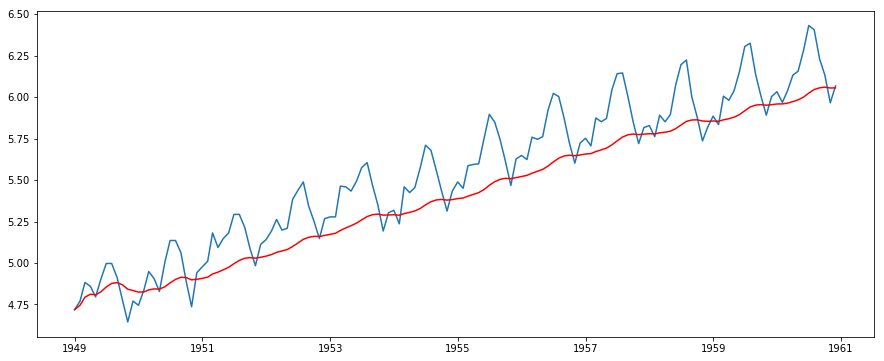

In [87]:
# Note that the parameter ‘halflife’ is used to define the amount of exponential decay.
exp_weighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color='red')

Now removing this trend from series and check stationarity:

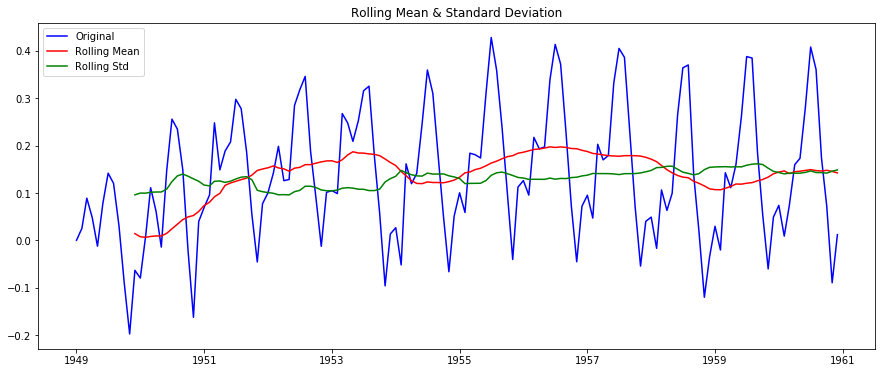

ADF Test Statistic              -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [88]:
ts_log_ewma_diff = ts_log - exp_weighted_avg
rolling_statistics(ts_log_ewma_diff)
adf_test(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

### Eliminating Trend and Seasonality

- Differencing – taking the differece with a particular time lag
- Decomposition – modeling both trend and seasonality and removing them from the model.

#### Differencing

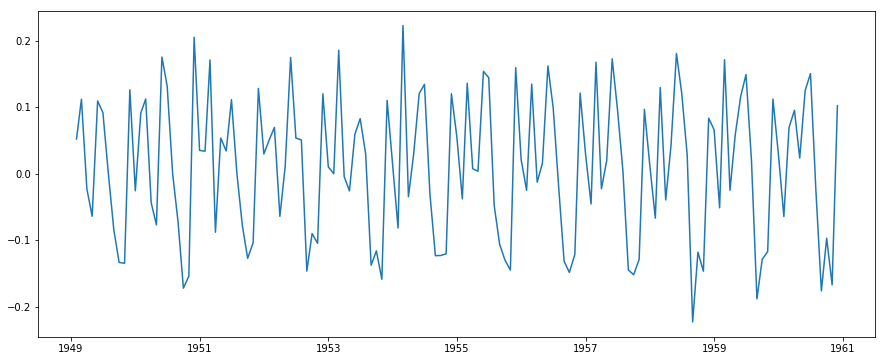

In [93]:
# First order differencing. ".shift()" - Shifts index by desired number of periods (default=1)
# Shifted one ahead and then subtracted from original
ts_log_differencing = ts_log - ts_log.shift()
plt.plot(ts_log_differencing)

From the above plot, we can see this appears to have reduced trend considerably.

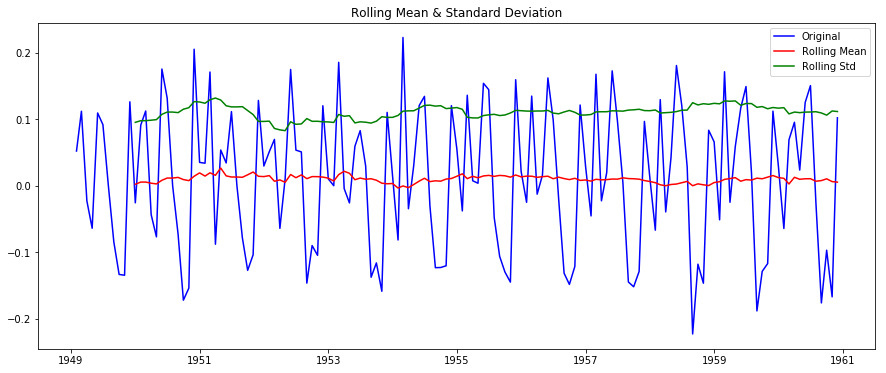

ADF Test Statistic              -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [94]:
ts_log_differencing.dropna(inplace=True)
rolling_statistics(ts_log_differencing)
adf_test(ts_log_differencing)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications.

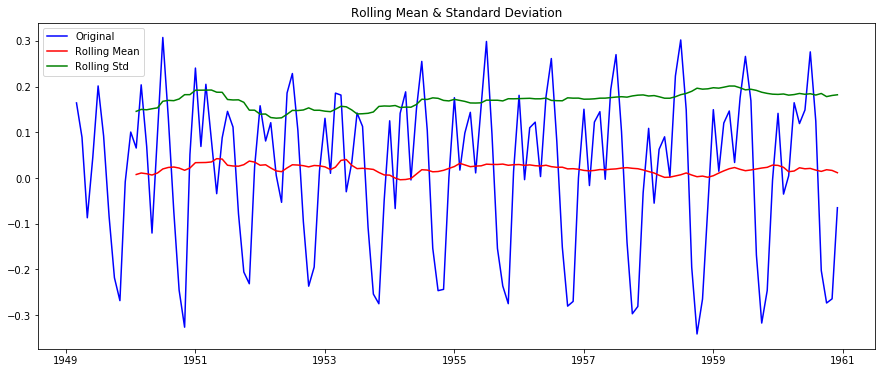

ADF Test Statistic              -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [99]:
# Second order differencing
ts_log_differencing_order2 = ts_log - ts_log.shift(periods=2)
ts_log_differencing_order2.dropna(inplace=True)
rolling_statistics(ts_log_differencing_order2)
adf_test(ts_log_differencing_order2)

From the above plot, the Dickey-Fuller test statistic is less than the 5% critical value, thus the TS is stationary with 95% confidence.

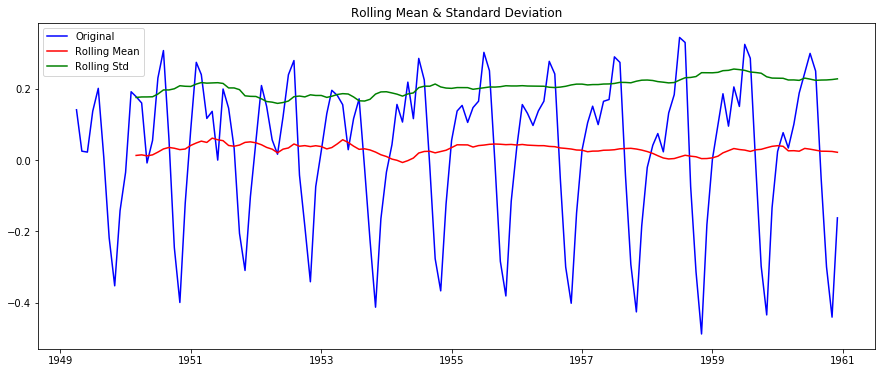

ADF Test Statistic              -2.728487
p-value                          0.069237
#Lags Used                      12.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [98]:
# Third order differencing
ts_log_differencing_order3 = ts_log - ts_log.shift(periods=3)
ts_log_differencing_order3.dropna(inplace=True)
rolling_statistics(ts_log_differencing_order3)
adf_test(ts_log_differencing_order3)

From the above plot, the Dickey-Fuller test statistic increases and is similar to the First Order differencing results.

#### Decomposing

In [103]:
from statsmodels.tsa.seasonal import seasonal_decompose

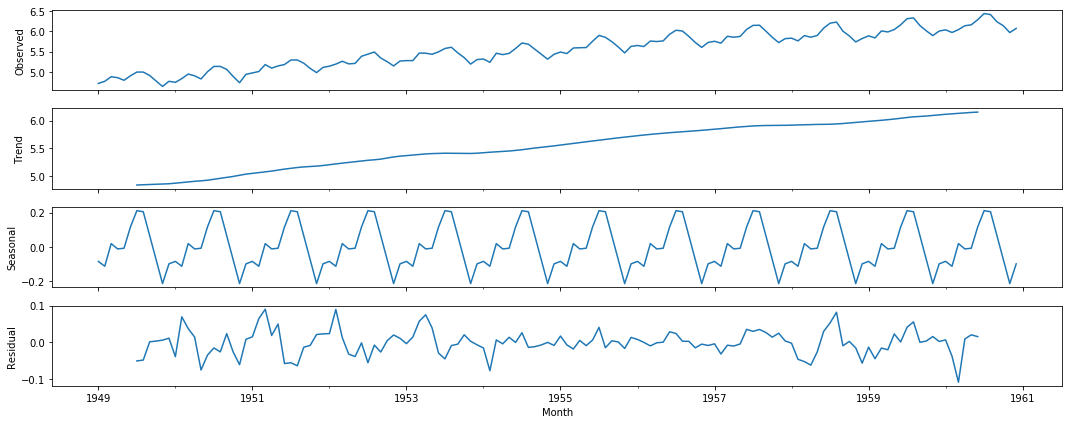

In [112]:
decomposition = seasonal_decompose(ts_log)
#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

decomposition.plot()
plt.show()

From the above plot, we can see that the trend and seasonality information extracted from the series does seem reasonable. The residuals are also showing periods of high variability in the early and later years of the series.

The trend, seasonality are separated out from data and we can model the residuals.

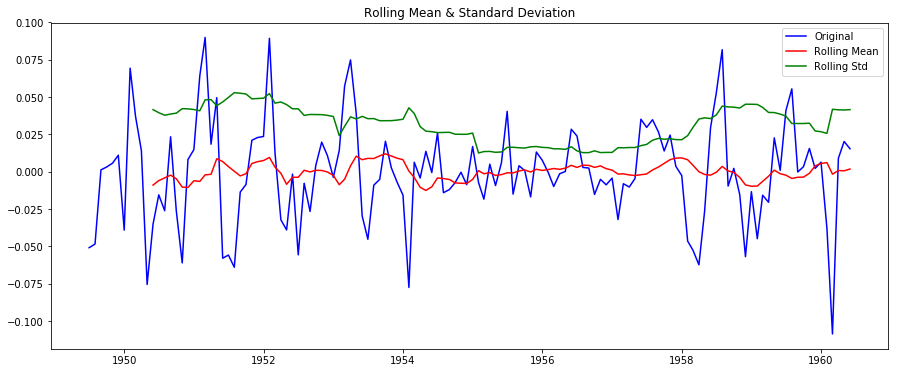

ADF Test Statistic            -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [115]:
# Check stationarity of residuals
ts_log_decompose = decomposition.resid
ts_log_decompose.dropna(inplace=True)
rolling_statistics(ts_log_decompose)
adf_test(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

## Forecasting a Time Series

### ARIMA

ARIMA stands for Auto-Regressive Integrated Moving Averages. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. *Number of AR (Auto-Regressive) terms (p):* AR terms are just lags of dependent variable.
2. *Number of MA (Moving Average) terms (q):* MA terms are lagged forecast errors in prediction equation.
3. *Number of Differences (d):* These are the number of nonseasonal differences.

To determine the value of ‘p’ and ‘q’, we use two plots to determine these numbers.

1. *Autocorrelation Function (ACF):* It is a measure of the correlation between the the TS with a lagged version of itself.
2. *Partial Autocorrelation Function (PACF):* This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [116]:
# Plotting ACF and PACF plots for the TS after differencing
from statsmodels.tsa.stattools import acf, pacf

In [117]:
lag_acf = acf(ts_log_differencing, nlags=20)
lag_pacf = pacf(ts_log_differencing, nlags=20)

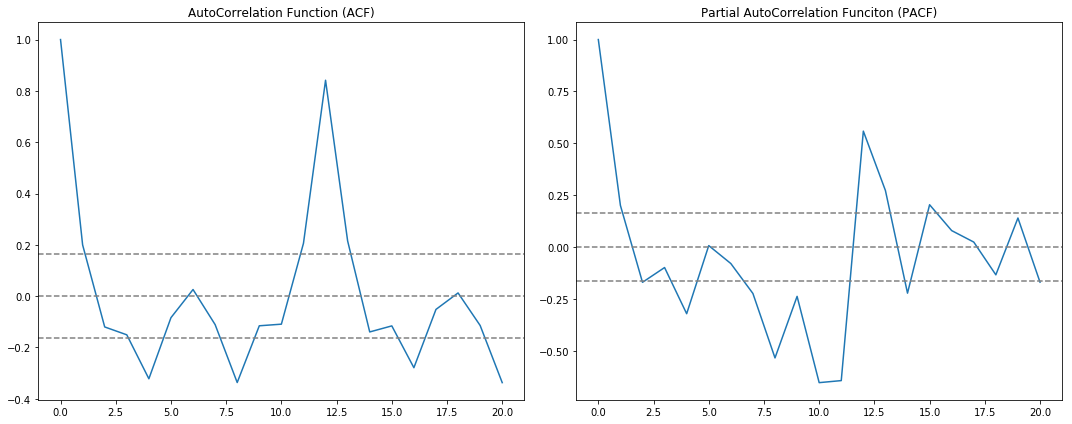

In [123]:
# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
# Upper confidence interval
plt.axhline(y=1.96/np.sqrt(len(ts_log_differencing)), linestyle='--', color='gray')
# Lower confidence interval
plt.axhline(y=-1.96/np.sqrt(len(ts_log_differencing)), linestyle='--', color='gray')
plt.title('AutoCorrelation Function (ACF)')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
# Upper confidence interval
plt.axhline(y=1.96/np.sqrt(len(ts_log_differencing)), linestyle='--', color='gray')
# Lower confidence interval
plt.axhline(y=-1.96/np.sqrt(len(ts_log_differencing)), linestyle='--', color='gray')
plt.title('Partial AutoCorrelation Funciton (PACF)')
plt.tight_layout()

In the above plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

- p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

Making 3 different ARIMA models - only AR, only MA and combined effects. Also computing the RSS (Residual sum of squares or Sum of Squared errors, SSE of prediction) for each model.

In [125]:
# Load the ARIMA model
from statsmodels.tsa.arima_model import ARIMA

# The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q).

#### AR Model

C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, np.float64):
C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, np.complex128):
C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, np.float64):


Text(0.5,1,'RSS: 1.5023')

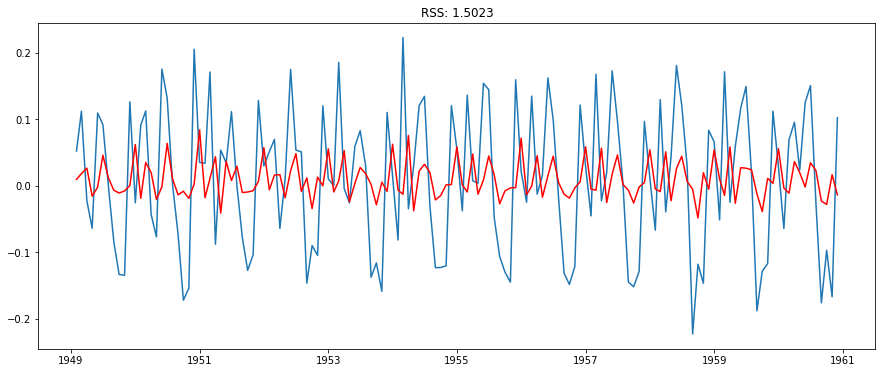

In [127]:
model_AR = ARIMA(ts_log, order=(2,1,0))
results_AR = model_AR.fit(disp=-1)
plt.plot(ts_log_differencing)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %0.4f' % sum((results_AR.fittedvalues - ts_log_differencing)**2))

#### MA model

C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, np.float64):
C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, np.complex128):
C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, np.float64):


Text(0.5,1,'RSS: 1.4721')

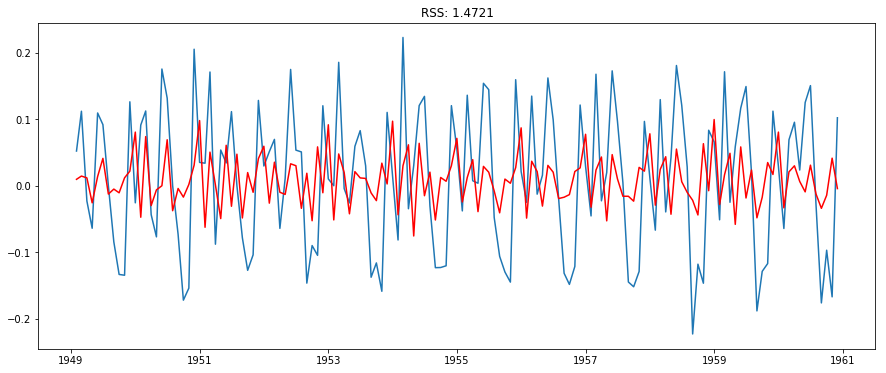

In [128]:
model_MA = ARIMA(ts_log, order=(0,1,2))
results_MA = model_MA.fit(disp=-1)
plt.plot(ts_log_differencing)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %0.4f' % sum((results_MA.fittedvalues - ts_log_differencing)**2))

#### Combined Model

C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, np.float64):
C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, np.complex128):
C:\Users\RavitThapar\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, np.float64):


Text(0.5,1,'RSS: 1.0292')

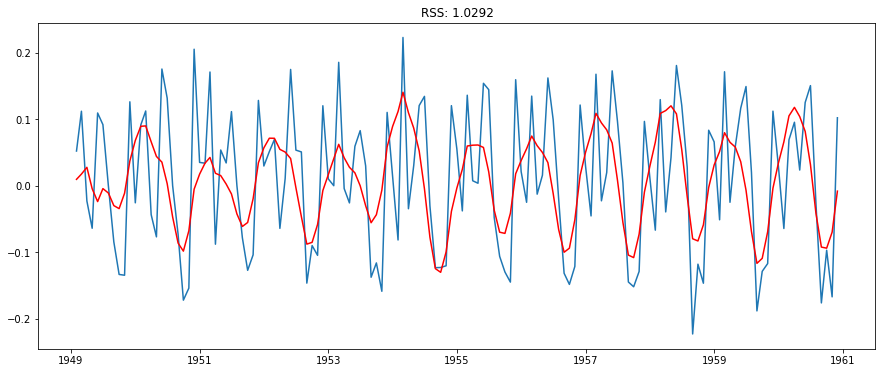

In [167]:
model_combined = ARIMA(ts_log, order=(2,1,2))
results_combined = model_combined.fit(disp=-1)
plt.plot(ts_log_differencing)
plt.plot(results_combined.fittedvalues, color='red')
plt.title('RSS: %0.4f' % sum((results_combined.fittedvalues - ts_log_differencing)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Now, taking these values back to the original scale.

#### Taking it back to original scale

In [130]:
pred_ARIMA_differencing = pd.Series(results_combined.fittedvalues, copy=True)
pred_ARIMA_differencing.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [131]:
pred_ARIMA_differencing_cumsum = pred_ARIMA_differencing.cumsum()
pred_ARIMA_differencing_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

Next we’ve to add them to base number. For this creating a series with all values as base number and add the differences to it. Thus removing the differencing transformation.

In [134]:
pred_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

In [135]:
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_differencing_cumsum, fill_value=0)
pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Now taking the exponent (since we performed the log transformaiton while eliminating trend) and compare with the original series.

Text(0.5,1,'RMSE: 90.1047')

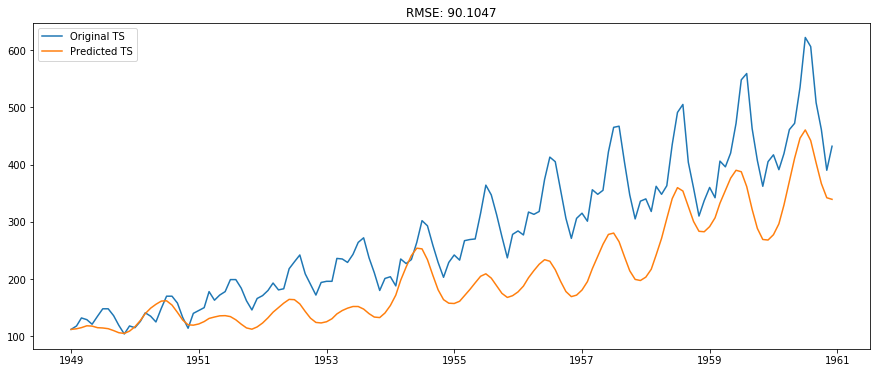

In [146]:
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(ts, label='Original TS')
plt.plot(pred_ARIMA, label='Predicted TS')
plt.legend(loc='best')
plt.title('RMSE: %0.4f' % np.sqrt(np.mean((pred_ARIMA - ts)**2)))

Finally we have a forecast at the original scale which is a close replication of the original Time-Series, although may need more refinement.